In [36]:
import os
import csv
import pandas as pd
import numpy as np

import datetime
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import squarify

from sklearn import model_selection, preprocessing, metrics
plt.style.use('fivethirtyeight')

print(os.getcwd())
print(os.listdir("../input/"))

/kaggle/working
['acm.csv']


In [37]:
#load dataframe from csv
df = pd.read_csv("../input/acm.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385066 entries, 0 to 2385065
Data columns (total 7 columns):
PaperTitle           object
Authors              object
Year                 float64
Publication_Venue    object
Index_Id             int64
References_Id        object
Abstract             object
dtypes: float64(1), int64(1), object(5)
memory usage: 127.4+ MB


In [5]:
df.shape

(2385066, 7)

In [6]:
df[df["Index_Id"] == 289023]

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract
289022,Shifting Graphs and Their Applications,"Nicholas Pippenger, Leslie G. Valiant",1976.0,Journal of the ACM (JACM),289023,:252607:288548:289037:289188:599901:600048:669...,Graphs that in a certain precise sense are ric...


***count_reference*** represents the number of times particular paper got referred in our dataset

In [6]:
df["count_reference"] = 0

In [8]:
df.isna().sum()

PaperTitle                46
Authors               151075
Year                    8428
Publication_Venue        139
Index_Id                   0
References_Id        1344739
Abstract              713788
count_reference            0
dtype: int64

In [7]:
df = df.dropna(axis=0,how='any')

In [8]:
df.isna().sum()

PaperTitle           0
Authors              0
Year                 0
Publication_Venue    0
Index_Id             0
References_Id        0
Abstract             0
count_reference      0
dtype: int64

In [9]:
df.shape

(977377, 8)

In [ ]:
df["Authors"].value_counts()

In [ ]:
temp_df = df.loc[df['Authors'].astype(str).str.startswith('-')]

In [ ]:
temp_df.shape

In [10]:
df = df.drop(df[df['Authors'].astype(str).str.startswith('-')].index)

In [ ]:
df.shape

####YEAR

In [ ]:
df["Year"] = df["Year"].fillna(0)
df["Year"] = df["Year"].astype(int)

**Rows with NaN year**

In [13]:
df[df["Year"] == 0]

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference


***Year of publication distribution in the data***

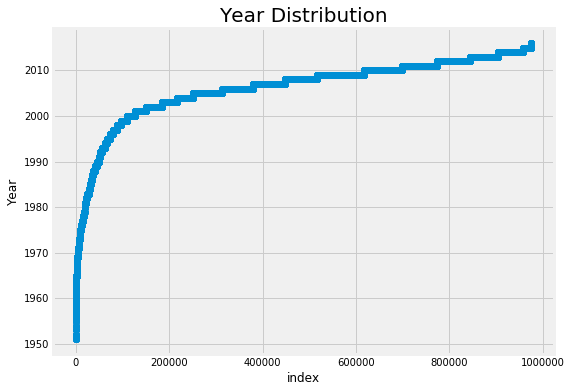

In [14]:
ydf = df[df["Year"]!=0]
plt.figure(figsize=(8,6))
plt.scatter(range(ydf.shape[0]), np.sort(ydf["Year"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.title("Year Distribution", fontsize=20) 
plt.show()

In [ ]:
df.isna().sum()

In [ ]:
print(df.dtypes)

In [ ]:
df["Index_Id"].unique()
print(any(df['Index_Id'].duplicated())) 
print(len(df['Index_Id'].unique()))
print(len(df.index))

> Index_Id = 2381731 is duplicated 9 times , It points to 7 different papers and has 82080 references.

In [15]:
df[df.duplicated(subset="Index_Id")]

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference


In [11]:
reference_count = {}
for references in df[df["References_Id"].notnull()]["References_Id"]:
    ref_list = map(int,references.strip(":").split(":"))
    for ref in ref_list:
        if ref in reference_count:
            reference_count[ref] += 1
        else:
            reference_count[ref] = 1
print(reference_count[2381731])

76236


In [12]:
def update_ref_count(row):
    if row['Index_Id'] in reference_count:
        return reference_count[row['Index_Id']]
    else:
        return 0
df["count_reference"] = df.apply(lambda row: update_ref_count(row),axis=1)

In [13]:
print(df.head(5))

                                            PaperTitle       ...       count_reference
117                     Algorithms for trie compaction       ...                    12
133  Logical, internal, and physical reference beha...       ...                     9
134    A parallel pipelined relational query processor       ...                     8
147           Practical data-swapping: the first steps       ...                    38
149  An extension of conflict-free multivalued depe...       ...                     3

[5 rows x 8 columns]


In [14]:
sorted_by_value = sorted(reference_count.items(), key=lambda kv: kv[1],reverse=True)
print(sorted_by_value[:10])
print([row[0] for row in sorted_by_value[:10]])
print([row[1] for row in sorted_by_value[:10]])

[(2135000, 884601), (2381731, 76236), (408395, 8038), (369235, 6269), (190580, 5233), (136349, 4726), (729436, 4439), (168250, 4413), (760804, 4147), (115607, 3360)]
[2135000, 2381731, 408395, 369235, 190580, 136349, 729436, 168250, 760804, 115607]
[884601, 76236, 8038, 6269, 5233, 4726, 4439, 4413, 4147, 3360]


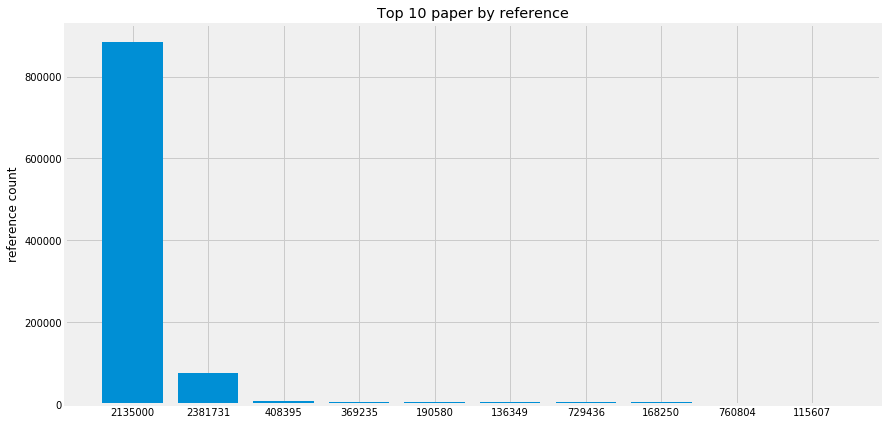

In [21]:
x_values = [row[0] for row in sorted_by_value[:10]]
y_values = [row[1] for row in sorted_by_value[:10]]
x_pos = np.arange(len(x_values))
plt.figure(figsize=(13,7))
plt.bar(x_pos,y_values, align='center', alpha=1)
plt.xticks(x_pos,x_values)
plt.ylabel('reference count')
plt.title('Top 10 paper by reference')
 
plt.show()

In [22]:
print(df.shape)
df.isna().sum()

(976233, 8)


PaperTitle           0
Authors              0
Year                 0
Publication_Venue    0
Index_Id             0
References_Id        0
Abstract             0
count_reference      0
dtype: int64

In [16]:
del reference_count
outlink_map = {}
inlink_map = {}
df_new = df[df["References_Id"].notnull()]
for index, row in df_new.iterrows():
    ref = row["References_Id"]
    ref_list = list(map(int,ref.strip(":").split(":")))
    outlink_map[row["Index_Id"]] = ref_list
    for ref in ref_list:
        listi = inlink_map.get(ref, [])
        listi.append(row["Index_Id"])
        inlink_map[ref] = listi

NameError: name 'reference_count' is not defined

In [17]:
def calculate_page_rank():
    count = 0
    page_year = {row["Index_Id"]:row["Year"] for _t, row in df.iterrows()}
    year_citation_count = { page_year[index]:0 for index in page_year}
    year_paper_count = { page_year[index]:0 for index in page_year}
    avg_year_citation_count = {}
    for index in page_year:
        year = page_year[index]
        len_outlink = len(outlink_map.get(index, []))
        if len_outlink > 0:
            year_citation_count[year] += len_outlink
            year_paper_count[year] += 1
    for year in year_citation_count:
        if year_paper_count[year] > 0:
            avg_year_citation_count[year] = year_citation_count[year]/year_paper_count[year]
    page_rank = {}
    updated_page_rank = {}
    for index in df["Index_Id"]:
        page_rank[index] = 1
    while True:
        count += 1
        flag = True
        for key in page_rank:
            cs = page_rank[key]
            if key in inlink_map:
                inlink_list = inlink_map[key]
                ns = 0
                for link in inlink_list:
                    if link in page_rank and link in outlink_map:
                        ns += page_rank[link]/len(outlink_map[link])
                #ns = 0.15 + (0.85 * ns)
                ns = 0.15 + float(0.85) * (ns/avg_year_citation_count[page_year[key]])
                if cs != ns:
                    flag = False
                updated_page_rank[key] = ns
        if flag == True:
            print(count)
            break
        page_rank = updated_page_rank
        updated_page_rank = {}
        max_score = max(page_rank.values())
        print(f"max score is {max_score}")
        page_rank = { index:score/max_score for index, score in page_rank.items()}
        return page_rank

In [18]:
page_rank = calculate_page_rank()
#del outlink_map
#del inlink_map

max score is 45.30006518885713


In [19]:
page_rank
print(max(page_rank.values()))
print(sum(page_rank.values()))

1.0
2617.283945650123


In [20]:
df["page_rank"] = 0

In [21]:
def update_rank(row):
    if row["Index_Id"] in page_rank:
        return page_rank[row["Index_Id"]]
    else:
        return 0

In [22]:
df["page_rank"] = df.apply(lambda row: update_rank(row),axis = 1)

In [23]:
df["page_rank"][0:10]

117    0.004683
133    0.005583
134    0.005590
147    0.010586
149    0.003931
315    0.008771
316    0.000000
317    0.007529
318    0.051573
319    0.005276
Name: page_rank, dtype: float64

In [24]:
df.head(5)

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,page_rank
117,Algorithms for trie compaction,"M. Al-Suwaiyel, E Horowitz",1984.0,ACM Transactions on Database Systems (TODS),118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.004683
133,"Logical, internal, and physical reference beha...","Wolfgang Effelsberg, Mary E. S. Loomis",1984.0,ACM Transactions on Database Systems (TODS),134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.005583
134,A parallel pipelined relational query processor,"Won Kim, Daniel Gajski, David J. Kuck",1984.0,ACM Transactions on Database Systems (TODS),135,:287004:287293:287666:287494:317954:321467:322...,This paper presents the design of a relational...,8,0.005590
147,Practical data-swapping: the first steps,Steven P. Reiss,1984.0,ACM Transactions on Database Systems (TODS),148,:287296:287297:289164:649353:2135000,The problem of statistical database confidenti...,38,0.010586
149,An extension of conflict-free multivalued depe...,Hirofumi Katsuno,1984.0,ACM Transactions on Database Systems (TODS),150,:287338:287676:289281:289349:289304:289423:374...,"Several researchers (Beeri, Bernstein, Chiu, F...",3,0.003931


In [ ]:
df["Number Of Authors"] = 0
def cal_authors(authors):
    author_list = authors.split(",")
    return len(author_list)
df["Number Of Authors"] = df["Authors"].apply(lambda val:cal_authors(val))
df["Number Of Authors"].value_counts()

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="darkgrid")
ax = sns.countplot(x="Number Of Authors", data=df)

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="darkgrid")
ax = sns.countplot(x="Year", data=df)

In [ ]:
import matplotlib.pylab as plt
lists = sorted(year_citation_count.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_vals = list(df_new["Publication_Venue"].values.astype(str))
le.fit(train_vals)
df_new["Publication_Venue"] = le.transform(train_vals)

In [25]:
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

In [26]:
df_new = tidy_split(df, 'Authors', sep=',')
df_new.head()

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,page_rank
117,Algorithms for trie compaction,M. Al-Suwaiyel,1984.0,ACM Transactions on Database Systems (TODS),118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.004683
117,Algorithms for trie compaction,E Horowitz,1984.0,ACM Transactions on Database Systems (TODS),118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.004683
133,"Logical, internal, and physical reference beha...",Wolfgang Effelsberg,1984.0,ACM Transactions on Database Systems (TODS),134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.005583
133,"Logical, internal, and physical reference beha...",Mary E. S. Loomis,1984.0,ACM Transactions on Database Systems (TODS),134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.005583
134,A parallel pipelined relational query processor,Won Kim,1984.0,ACM Transactions on Database Systems (TODS),135,:287004:287293:287666:287494:317954:321467:322...,This paper presents the design of a relational...,8,0.005590


In [28]:
#df_new = b
df_new.shape

(2824936, 9)

In [33]:
train_vals = list(df_new["Authors"].values.astype(str))
le.fit(train_vals)
df_new["Authors"] = le.transform(train_vals)

In [ ]:
df_new.to_csv("ranked_processed_acm_1.csv")

In [35]:
df_new.head(5)

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,page_rank
117,Algorithms for trie compaction,207770,1984.0,11564,118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.004683
117,Algorithms for trie compaction,218707,1984.0,11564,118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.004683
133,"Logical, internal, and physical reference beha...",84699,1984.0,11564,134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.005583
133,"Logical, internal, and physical reference beha...",558533,1984.0,11564,134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.005583
134,A parallel pipelined relational query processor,88995,1984.0,11564,135,:287004:287293:287666:287494:317954:321467:322...,This paper presents the design of a relational...,8,0.005590


In [ ]:
num_columns= ["Year","Publication_Venue","Index_Id","count_reference","Number Of Authors"]
df_train = df[num_columns]

In [ ]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(df_train, df["page_rank"], test_size=0.25, random_state=20)

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(train_x,train_y)
print(reg.coef_)

In [ ]:
from sklearn import metrics
pred_y = reg.predict(valid_x)
rmse_initial = np.sqrt(metrics.mean_squared_error(pred_y,valid_y))
print(rmse_initial)